In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
import math
import time
from tensorflow.keras.layers import Input,Conv2D,Dense,Dropout,Lambda, GlobalAveragePooling2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import plot_model,normalize

# from pylab import dist

from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score


In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
height = 369
width = 496

In [4]:
np.random.default_rng(2021)
sample_indices = np.random.randint(0,y_train.size, size=500) # Setting fixed indices for testing

In [5]:
def get_first_500():
    return x_train[sample_indices]
#     return x_train[:500], y_train[:500]

In [6]:
x_anc = x_train[sample_indices[1]]  
y = y_train[sample_indices[1]]

In [7]:
def make_triplet(index):
    triplet = np.zeros((3,height,width,1))
    
    x_anchor = x_train[index]
    y = y_train[index]
    
    pos_inds = np.where(y_train==y)[0] #Getting same artist song
    pos_inds = np.delete(pos_inds,np.where(pos_inds==index))
    pos_sel = np.random.choice(pos_inds,1) 
    
    neg_inds = np.where(y_train!=y)[0] #Getting diff artist song
    neg_sel = np.random.choice(neg_inds,1) 

    x_pos =  x_train[pos_sel]
    x_neg =  x_train[neg_sel]
    
    triplet[0] = x_anchor
    triplet[1] = x_pos
    triplet[2] = x_neg
#     print(triplet.shape)
    return triplet

def create_hard_batch(alpha,batch_size=256):
    ini_batch = [] 
    hard_indices = []

    sample_size = batch_size #512
    
    sample_indices = np.random.randint(0,y_train.size, size=sample_size)
    
    for i in range(0,sample_size):
        ini_batch.append(make_triplet(sample_indices[i]))
        a_emb = embedding_model.predict(tf.expand_dims(ini_batch[i][0], axis=0))
        p_emb = embedding_model.predict(tf.expand_dims(ini_batch[i][1], axis=0))
        n_emb = embedding_model.predict(tf.expand_dims(ini_batch[i][2], axis=0))
        
        dAP = np.linalg.norm(a_emb -p_emb) #Should this be negated like in compute_prob func?
        dAN = np.linalg.norm(a_emb- n_emb)
        
        if(dAN - dAP < alpha and dAN >= dAP):
            hard_indices.append(i) # Maintaining record of hard indices so can be added later
            
    x_anchors = np.zeros((len(hard_indices), height,width,1))
    x_positives = np.zeros((len(hard_indices), height,width,1))
    x_negatives = np.zeros((len(hard_indices), height,width,1))
    
#     print(np.array(final_batch).shape)
    
    j=0
    
    for ind in hard_indices:
        x_anchors[j] = ini_batch[ind][0]
        x_positives[j] = ini_batch[ind][1]
        x_negatives[j] = ini_batch[ind][2]
        j+=1
        
#     x_anchors =  x_anchors.reshape(x_anchors.shape[0], height, width, 1)
#     x_positives =  x_positives.reshape(x_positives.shape[0], height, width, 1)
#     x_negatives =  x_negatives.reshape(x_negatives.shape[0], height, width, 1)
    triplets = [x_anchors, x_positives, x_negatives]
        
    return triplets

In [8]:
# x = make_triplet()
t = time.time()
x = create_hard_batch(0.2,256) #EXPONENTIAL TIME dont keep 1024
print(time.time()-t)

NameError: name 'embedding_model' is not defined

In [183]:
# embedding_model.predict(tf.expand_dims(x_train[3], axis=0))

In [9]:
#constants
alpha = 0.2
emb_size = 32

In [10]:
def make_embedding_model(input_shape=(height,width,1),emb_size=32): #inp shape has to be of form (height,width)
    inputs = Input(input_shape);
    x = Conv2D(16, (5, 5), padding="same", activation="relu", kernel_regularizer=l2(1e-3),kernel_initializer='he_uniform')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(32, (5,5), padding="same",  activation="relu",kernel_regularizer=l2(1e-3),kernel_initializer='he_uniform')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (3,3),   activation="relu",kernel_regularizer=l2(1e-3),kernel_initializer='he_uniform')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (3,3),   activation="relu",kernel_regularizer=l2(1e-3),kernel_initializer='he_uniform')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (3,3),   activation="relu",kernel_regularizer=l2(1e-3),kernel_initializer='he_uniform')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
#     x = Flatten()(x)
    
#     x = Dense(512, activation='relu')(x)
#     x = Dense(128, activation='relu')(x)
#     Output = Dense(32, activation='relu')(x)
    
    
    pooledOutput = GlobalAveragePooling2D()(x)
    
    outputs = Dense(emb_size,kernel_regularizer=l2(1e-3),kernel_initializer='he_uniform')(pooledOutput)
    
    model = Model(inputs, outputs)
    model.summary()
    
    return model
    

In [11]:
input_shape = (height,width,1)
# print(input_shape)
def SNN(embedding_model):
    input_anchor = Input(shape=input_shape)
    input_positive = Input(shape=input_shape)
    input_negative = Input(shape=input_shape)
    
    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)
    
    output = tf.keras.layers.concatenate([embedding_anchor,embedding_positive, embedding_negative],axis=1) 
    # Weird thing where only tf.keras works not Concatenate
    
    siamese_net = Model([input_anchor, input_positive, input_negative], output)
    
    siamese_net.summary()
#     plot_model(siamese_net,show_shapes=True, show_layer_names=True)
    
    return siamese_net

In [12]:
def triplet_loss(y_true,y_pred):
#     print(y_pred.shape[0])
    anchor, pos, neg = y_pred[:,:emb_size],y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    dAP = tf.norm(anchor-pos)
    dAN = tf.norm(anchor-neg)
    return tf.maximum(pos - neg + alpha, 0)

In [13]:
# def data_generator(batch_size=256, alpha=0.2):
#     while True:
#         x,alpha = create_hard_batch(alpha,batch_size)
#         y = np.zeros((batch_size, 3*emb_size))
#         yield x,y

In [14]:
#COPY PASTE from https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352
# Well not really updated but func is genrally same

def compute_dist(a,b):
    return np.linalg.norm(a-b)

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings 
        X : tensor of shape (m,h,w,1) containing pics to evaluate => m is 500
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2) # => 500C2 => like 124,000
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all imgs with current embedding network
    embeddings = embedding_model.predict(X)
    
    k = 0
    
    # For each img in the evaluation set
    for i in range(m):
            # Against all other images
            for j in range(i+1,m):
                # compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tSAME".format(i,j,probs[k],k, Y[i], Y[j]))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : {2}\tDIFF".format(i,j,probs[k],k, Y[i], Y[j]))
                k += 1
    return probs, y

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    return fpr, tpr, thresholds,auc

def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx

def draw_interdist(network, epochs):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(num_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} epochs'.format(epochs))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(num_classes))

    plt.show()

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (num_classes,num_classes) 
    '''
    res = np.zeros((num_classes,num_classes))
    
    ref_images = np.zeros((num_classes, height,width, 1))
    
    #generates embeddings for reference images
    for i in range(6):
        ref_images[i,:,:,:] = x_train[i*6,:,:,:]
    
    ref_embeddings = network.predict(ref_images)
    
    for i in range(num_classes):
        for j in range(num_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j]) #Should it be negative?
    return res


def evaluate(embedding_model, epochs=0):
    probs, yprob = compute_probs(embedding_model, x_test[:100], y_test[:100])
    fpr, tpr, thresholds, auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr, thresholds, auc)
    draw_interdist(embedding_model, epochs)
    
#     for i in range(3):
#         DrawTestImage(embedding_model, np.expand_dims(x_train[i],axis=0)) 
#Maybe later cuz gotta fix abv func

In [22]:
# More fns unused as to be adapted

'''def generate_prototypes(x_data, y_data, embedding_model):
    classes = np.unique(y_data)
    prototypes = {}

    for c in classes:
        #c = classes[0]
        # Find all images of the chosen test class
        locations_of_c = np.where(y_data == c)[0]

        imgs_of_c = x_data[locations_of_c]

        imgs_of_c_embeddings = embedding_model.predict(imgs_of_c)

        # Get the median of the embeddings to generate a prototype for the class (reshaping for PCA)
        prototype_for_c = np.median(imgs_of_c_embeddings, axis = 0).reshape(1, -1)
        # Add it to the prototype dict
        prototypes[c] = prototype_for_c
        
    return prototypes
         
def test_one_shot_prototypes(network, sample_embeddings):
    distances_from_img_to_test_against = []
    # As the img to test against is in index 0, we compare distances between img@0 and all others
    for i in range(1, len(sample_embeddings)):
        distances_from_img_to_test_against.append(compute_dist(sample_embeddings[0], sample_embeddings[i]))
    # As the correct img will be at distances_from_img_to_test_against index 0 (sample_imgs index 1),
    # If the smallest distance in distances_from_img_to_test_against is at index 0, 
    # we know the one shot test got the right answer
    is_min = distances_from_img_to_test_against[0] == min(distances_from_img_to_test_against)
    is_max = distances_from_img_to_test_against[0] == max(distances_from_img_to_test_against)
    return int(is_min and not is_max)
    
def n_way_accuracy_prototypes(n_val, n_way, network):
    num_correct = 0
    
    for val_step in range(n_val):
        num_correct += load_one_shot_test_batch_prototypes(n_way, network)
        
    accuracy = num_correct / n_val * 100
        
    return accuracy

def load_one_shot_test_batch_prototypes(n_way, network):
    
    labels = np.unique(y_test)
    # Reduce the label set down from size n_classes to n_samples 
    labels = np.random.choice(labels, size = n_way, replace = False)

    # Choose a class as the test image
    label = random.choice(labels)
    # Find all images of the chosen test class
    imgs_of_label = np.where(y_test == label)[0]

    # Randomly select a test image of the selected class, return it's index
    img_of_label_idx = random.choice(imgs_of_label)

    # Expand the array at the selected indexes into useable images
    img_of_label = np.expand_dims(x_test[img_of_label_idx],axis=0)
    
    sample_embeddings = []
    # Get the anchor image embedding
    anchor_prototype = network.predict(img_of_label)
    sample_embeddings.append(anchor_prototype)
    
    # Get the prototype embedding for the positive class
    positive_prototype = prototypes[label]
 
    sample_embeddings.append(positive_prototype)
    
    # Get the negative prototype embeddings
    # Remove the selected test class from the list of labels based on it's index 
    label_idx_in_labels = np.where(labels == label)[0]
    other_labels = np.delete(labels, label_idx_in_labels)
    
    # Get the embedding for each of the remaining negatives
    for other_label in other_labels:
        negative_prototype = prototypes[other_label]
        sample_embeddings.append(negative_prototype)
                
    correct = test_one_shot_prototypes(network, sample_embeddings)

    return correct


def visualise_n_way_prototypes(n_samples, network):
    labels = np.unique(y_test)
    # Reduce the label set down from size n_classes to n_samples 
    labels = np.random.choice(labels, size = n_samples, replace = False)

    # Choose a class as the test image
    label = random.choice(labels)
    # Find all images of the chosen test class
    imgs_of_label = np.where(y_test == label)[0]

    # Randomly select a test image of the selected class, return it's index
    img_of_label_idx = random.choice(imgs_of_label)

    # Get another image idx that we know is of the test class for the sample set
    label_sample_img_idx = random.choice(imgs_of_label)

    # Expand the array at the selected indexes into useable images
    img_of_label = np.expand_dims(x_test[img_of_label_idx],axis=0)
    label_sample_img = np.expand_dims(x_test[label_sample_img_idx],axis=0)
    
    # Make the first img in the sample set the chosen test image, the second the other image
    sample_imgs = np.empty((0, x_test_w_h))
    sample_imgs = np.append(sample_imgs, img_of_label, axis=0)
    sample_imgs = np.append(sample_imgs, label_sample_img, axis=0)
    
    sample_embeddings = []
    
    # Get the anchor embedding image
    anchor_prototype = network.predict(img_of_label)
    sample_embeddings.append(anchor_prototype)
    
    # Get the prototype embedding for the positive class
    positive_prototype = prototypes[label]
    sample_embeddings.append(positive_prototype)

    # Get the negative prototype embeddings
    # Remove the selected test class from the list of labels based on it's index 
    label_idx_in_labels = np.where(labels == label)[0]
    other_labels = np.delete(labels, label_idx_in_labels)
    # Get the embedding for each of the remaining negatives
    for other_label in other_labels:
        negative_prototype = prototypes[other_label]
        sample_embeddings.append(negative_prototype)
        
        # Find all images of the other class
        imgs_of_other_label = np.where(y_test == other_label)[0]
        # Randomly select an image of the selected class, return it's index
        another_sample_img_idx = random.choice(imgs_of_other_label)
        # Expand the array at the selected index into useable images
        another_sample_img = np.expand_dims(x_test[another_sample_img_idx],axis=0)
        # Add the image to the support set
        sample_imgs = np.append(sample_imgs, another_sample_img, axis=0)
    
    distances_from_img_to_test_against = []
    
    # As the img to test against is in index 0, we compare distances between img@0 and all others
    for i in range(1, len(sample_embeddings)):
        distances_from_img_to_test_against.append(compute_dist(sample_embeddings[0], sample_embeddings[i]))
        
    # + 1 as distances_from_img_to_test_against doesn't include the test image
    min_index = distances_from_img_to_test_against.index(min(distances_from_img_to_test_against)) + 1
    
    return sample_imgs, min_index'''


"def generate_prototypes(x_data, y_data, embedding_model):\n    classes = np.unique(y_data)\n    prototypes = {}\n\n    for c in classes:\n        #c = classes[0]\n        # Find all images of the chosen test class\n        locations_of_c = np.where(y_data == c)[0]\n\n        imgs_of_c = x_data[locations_of_c]\n\n        imgs_of_c_embeddings = embedding_model.predict(imgs_of_c)\n\n        # Get the median of the embeddings to generate a prototype for the class (reshaping for PCA)\n        prototype_for_c = np.median(imgs_of_c_embeddings, axis = 0).reshape(1, -1)\n        # Add it to the prototype dict\n        prototypes[c] = prototype_for_c\n        \n    return prototypes\n         \ndef test_one_shot_prototypes(network, sample_embeddings):\n    distances_from_img_to_test_against = []\n    # As the img to test against is in index 0, we compare distances between img@0 and all others\n    for i in range(1, len(sample_embeddings)):\n        distances_from_img_to_test_against.append(comp

Generating embedding model... 

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 369, 496, 1)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 369, 496, 16)      416       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 184, 248, 16)      0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 184, 248, 16)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 184, 248, 32)      12832     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 92, 124, 32)       0         
_________________________________________________________________
dropout_31 (Dropout)      

C:\Users\Vignesh\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


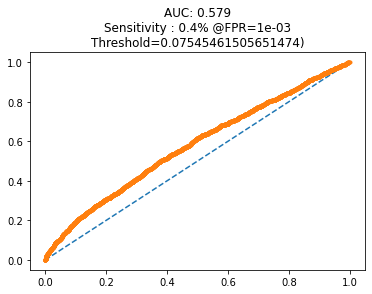

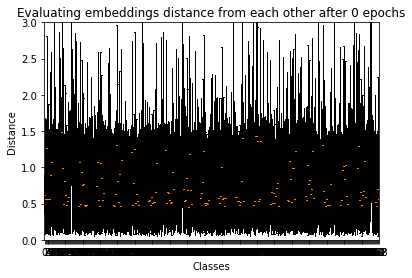

In [197]:
# Training

num_classes = 354 #should be made dynamic
batch_size = 256
epochs = 15 #100
steps_per_epoch = int(x_train.shape[0]/batch_size)
# val_steps = int(x_test.shape[0]/batch_size)
alpha = 0.2
num_hard = int(batch_size * 0.5) # Number of semi-hard triplet examples in the batch
lr = 0.00006
optimiser = 'Adam'
emb_size = 32 # 10 in mnist
input_size = (369,496,1)

with tf.device("/cpu:0"):
    # Create the embedding model
    print("Generating embedding model... \n")
    embedding_model = make_embedding_model(emb_size=emb_size) #maybe dec input size (369,496) 
    
    print("\nGenerating SNN... \n")
    # Create the SNN
    siamese_net = SNN(embedding_model)
    # Compile the SNN
    optimiser_obj = Adam(lr = lr)
    siamese_net.compile(loss=triplet_loss, optimizer= optimiser_obj)
    
    # Store visualisations of the embeddings using PCA for display next to "after training" for comparisons
    num_vis = 500 # Take only the first num_vis elements of the test set to visualise
#     embeddings_before_train = embedding_model.predict(get_first_500())
#     pca = PCA(n_components=2)
#     decomposed_embeddings_before = pca.fit_transform(embeddings_before_train)

print("\nEvaluating the model without training for a baseline...\n")
evaluate(embedding_model)

#### DO CALLBACKS LATER

# Save model configs to JSON
# model_json = siamese_net.to_json()
# with open(os.path.join(logdir, "siamese_config.json"), "w") as json_file:
#     json_file.write(model_json)
#     json_file.close()
    
# model_json = embedding_model.to_json()
# with open(os.path.join(logdir, "embedding_config.json"), "w") as json_file:
#     json_file.write(model_json)
#     json_file.close()
    
# hyperparams = {'batch_size' : batch_size,
#               'epochs' : epochs, 
#                'steps_per_epoch' : steps_per_epoch, 
#                'val_steps' : val_steps, 
#                'alpha' : alpha, 
#                'num_hard' : num_hard, 
#                'optimiser' : optimiser,
#                'lr' : lr,
#                'emb_size' : emb_size
#               }

# with open(os.path.join(logdir, "hyperparams.json"), "w") as json_file:
#     json.dump(hyperparams, json_file)

def delete_older_model_files(filepath):
    
    model_dir = filepath.split("emb_model")[0]
    
    # Get model files
    model_files = os.listdir(model_dir)

    # Get only the emb_model files
    emb_model_files = [file for file in model_files if "emb_model" in file]
    # Get the epoch nums of the emb_model_files
    emb_model_files_epoch_nums = [int(file.split("-")[1].split(".h5")[0]) for file in emb_model_files]

    # Find all the snn model files
    snn_model_files = [file for file in model_files if "snn_model" in file]

    # Sort, get highest epoch num
    emb_model_files_epoch_nums.sort()
    highest_epoch_num = str(emb_model_files_epoch_nums[-1]).zfill(2)

    # Filter the emb_model and snn_model file lists to remove the highest epoch number ones
    emb_model_files_without_highest = [file for file in emb_model_files if highest_epoch_num not in file]
    snn_model_files_without_highest = [file for file in snn_model_files if ("-" + highest_epoch_num + "-") not in file]

    # Delete the non-highest model files from the subdir
    if len(emb_model_files_without_highest) != 0:
        print("Deleting previous best model file")
    for model_file_list in [emb_model_files_without_highest, snn_model_files_without_highest]:
        for file in model_file_list:
            os.remove(os.path.join(model_dir, file))

In [190]:
x = get_first_500()

In [191]:
x.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [210]:
print("Starting training process!")
print("-------------------------------------")

# Make the model work over the two GPUs we have
# num_gpus = get_num_gpus()
# parallel_snn = multi_gpu_model(siamese_net, gpus = num_gpus)
# batch_per_gpu = int(batch_size / num_gpus)
siamese_net.compile(loss=triplet_loss, optimizer= optimiser_obj)

n_iter = 10 #1000
n_iteration = 0
evaluate_every = 2
t_start = time.time() 

for i in range(1, n_iter+1):
    triplets = create_hard_batch(batch_size=100,alpha=0.2)
    triplet_count = triplets[0].shape[0]
    if(triplet_count < 0.1*100):
        print("Got only", triplet_count,"triplets, increasing alpha")
        alpha += 0.25
    #Check alpha here and update
    loss = siamese_net.train_on_batch(triplets, None)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,loss,n_iteration))
        probs,yprob = compute_probs(embedding_model,x_test[:200], y_test[:200])
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr)


print("-------------------------------------")
print("Training complete.")


Starting training process!
-------------------------------------

 ------------- 

[0] Time for 1 iterations: 0.3 mins, Train Loss: 0.5427433252334595

 ------------- 

[0] Time for 2 iterations: 0.8 mins, Train Loss: 0.5420041084289551

 ------------- 

[0] Time for 3 iterations: 1.3 mins, Train Loss: 0.5412631630897522

 ------------- 

[0] Time for 4 iterations: 1.7 mins, Train Loss: 0.5405215620994568

 ------------- 

[0] Time for 5 iterations: 2.2 mins, Train Loss: 0.5397797226905823
Got only 9 triplets, increasing alpha

 ------------- 

[0] Time for 6 iterations: 2.7 mins, Train Loss: 0.5390379428863525

 ------------- 

[0] Time for 7 iterations: 3.1 mins, Train Loss: 0.5382964611053467

 ------------- 

[0] Time for 8 iterations: 3.6 mins, Train Loss: 0.5375552773475647

 ------------- 

[0] Time for 9 iterations: 4.0 mins, Train Loss: 0.5368145704269409

 ------------- 

[0] Time for 10 iterations: 4.5 mins, Train Loss: 0.5360743999481201
------------------------------------

In [211]:
# do analysis
#other funcs